# Imports

In [1]:
import cudf as pd
import cupy
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random
import shap
import seaborn as sns
import tensorflow as tf

from cuml import RandomForestRegressor as CudaRandomForest
from cuml.metrics import mean_absolute_error
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()
dask.config.set(scheduler="threads", num_workers=30)


2024-08-29 23:13:08.618230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 23:13:08.618300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 23:13:08.619865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 23:13:08.630450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 23:13:10.354579: W tensorflow/compiler/tf2

# Dataset
## Load

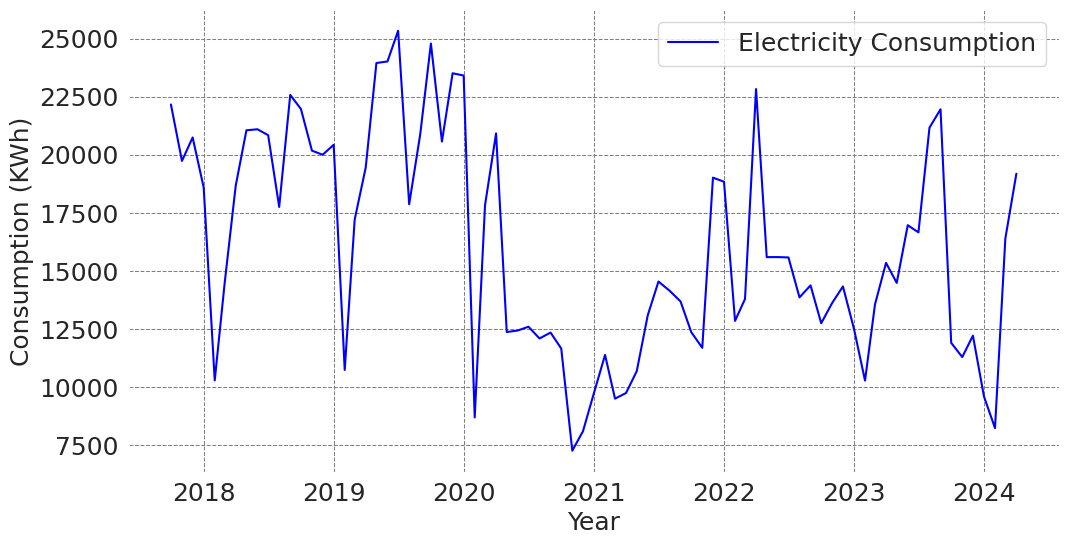

,year,month,consumption,covid
date,,,,
2017-09-30,2017,9,22163,0.0
2017-10-31,2017,10,19732,0.0
2017-11-30,2017,11,20742,0.0
2017-12-31,2017,12,18585,0.0
2018-01-31,2018,1,10280,0.0
...,...,...,...,...
2023-11-30,2023,11,12207,0.0
2023-12-31,2023,12,9588,0.0
2024-01-31,2024,1,8226,0.0


In [2]:
df = pd.read_csv('dataset - Palmas/electricity.csv', sep=";", decimal=",", header=0)
df_climatic = pd.read_csv('dataset - Palmas/climatic.csv', sep=";", decimal=",", header=0)

df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")

df.drop("order", axis=1, inplace=True)
df.set_index("date", inplace=True)
df_climatic.set_index("date", inplace=True)

plt.figure(figsize=(12, 6))
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams.update({'font.size': 18})
plt.plot(df["consumption"], label="Electricity Consumption", color="blue")
plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.75)
plt.legend(facecolor='white')
plt.savefig("results - Palmas 12m/Serie.png", bbox_inches='tight')
plt.show()

df


## Autocorrelation

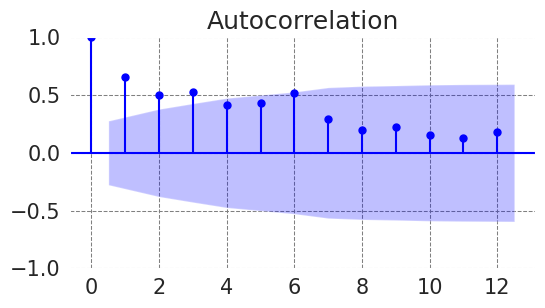

In [3]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue"])

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.75)

plot_acf(df[:50]["consumption"].to_pandas(), ax=ax, lags=12)
plt.savefig("results - Palmas 12m/CORR-ACF.png", bbox_inches='tight')
plt.show()


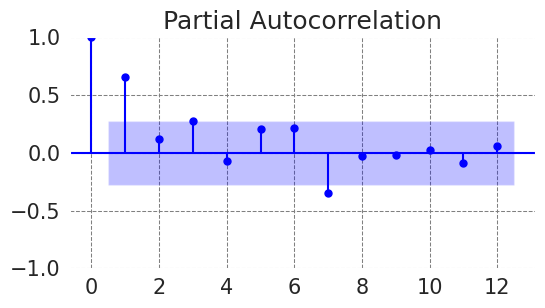

In [4]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue"])

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.75)

plot_pacf(df[:50]["consumption"].to_pandas(), ax=ax, lags=12)
plt.savefig("results - Palmas 12m/CORR-PACF.png", bbox_inches='tight')
plt.show()


## Hypotesis Tests

The hypothesis tests were carried out in the R language, according to the "Hypotesis Tests.R" File.

# Preprocessing
## Missing Values

In [5]:
for index, row in df_climatic[df_climatic.isnull()].to_pandas().iterrows():
    df_mes = df_climatic[df_climatic["month"] == df_climatic.at[index, "month"]]
    for col in row.index:
        if pandas.isnull(df_climatic.at[index, col]):
            df_mes.at[index, col] = df_mes[col].sum() / df_mes[col][df_mes[col].isnull() == False].count()
            df_climatic.at[index, col] = df_mes.at[index, col]


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cudf/core/series.py:264: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '161310.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  warnings.warn(
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cudf/core/series.py:264: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '161310.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  warnings.warn(


## LAG Creation

In [6]:
for lag_col in ["consumption"]:
    for i in range(1, 12 + 1):
        lag_eletricity = df[lag_col].shift(i)
        df[f'LAG_' + '{:02d}'.format(i)] = lag_eletricity


## Datasets Merge

In [7]:
df = pd.merge(left=df, right=df_climatic, on=["date", "month", "year"], how="left").sort_index()
df

,year,month,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_04,LAG_05,LAG_06,...,windvel,maxtemp_abs,maxtemp_mean,maxtemp_mean_abs,mintemp_abs,mintemp_mean,mintemp_mean_abs,windmaxvel_abs,windmaxvel_mean,windmaxvel_mean_abs
date,,,,,,,,,,,,,,,,,,,,,
2017-09-30,2017,9,22163,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-10-31,2017,10,19732,0.0,22163,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-11-30,2017,11,20742,0.0,19732,22163,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-12-31,2017,12,18585,0.0,20742,19732,22163,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-01-31,2018,1,10280,0.0,18585,20742,19732,22163,<NA>,<NA>,...,2.82,29.3,20.34,25.57,9.7,19.15,16.09,14.5,5.56,9.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,2024,3,19182,0.0,16390,8226,9588,12207,11286,11897,...,2.36,30.8,21.11,26.83,12.7,19.95,16.22,15.2,4.6,8.01
2024-04-30,2024,4,13706,0.0,19182,16390,8226,9588,12207,11286,...,2.393333333,28.36666667,17.57833333,23.45166667,5.583333333,16.315,12.23666667,13.03333333,4.71,8.09
2024-05-31,2024,5,14224,0.0,13706,19182,16390,8226,9588,12207,...,2.355,25.95,14.59,20.17166667,1.866666667,13.41833333,9.383333333,13.91666667,4.596666667,8.106666667


## Dummy Variables Creation

In [8]:
df_meses = pd.get_dummies(df["month"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "month_JAN", "2": "month_FEV", "3": "month_MAR", "4": "month_ABR", "5": "month_MAI", "6": "month_JUN",
             "7": "month_JUL", "8": "month_AGO", "9": "month_SET", "10": "month_OUT", "11": "month_NOV",
             "12": "month_DEZ"}
)
df_anos = pd.get_dummies(df["year"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "year_2017", "2018": "year_2018", "2019": "year_2019", "2020": "year_2020", "2021": "year_2021",
             "2022": "year_2022", "2023": "year_2023", "2024": "year_2024"}
)
df = pd.concat([df, df_meses, df_anos], axis=1)
df = df.drop(["month", "year"], axis=1)
df = df.astype("float32").dropna()

df_show = df.to_pandas()
df_show

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_04,LAG_05,LAG_06,LAG_07,LAG_08,...,month_NOV,month_DEZ,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
date,,,,,,,,,,,,,,,,,,,,,
2018-09-30,21969.0,0.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,10280.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-31,20174.0,0.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-30,19998.0,0.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,20426.0,0.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-31,10732.0,0.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,19182.0,0.0,16390.0,8226.0,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-04-30,13706.0,0.0,19182.0,16390.0,8226.0,9588.0,12207.0,11286.0,11897.0,21955.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-05-31,14224.0,0.0,13706.0,19182.0,16390.0,8226.0,9588.0,12207.0,11286.0,11897.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
df_merged = pd.read_csv('elect_merged_selected.csv', sep=";", decimal=",", header=0).set_index(
    "date")
df_selected = df[df_merged.columns]
df_selected.to_pandas().to_csv(f"dataset - Palmas/elect_merged_selected.csv", sep=";", decimal=",")
df_selected

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_06,LAG_12,maxtemp_mean_abs,mintemp_abs,windmaxvel_abs,month_MAR,year_2019
date,,,,,,,,,,,,
2018-09-30,21969.0,0.0,22575.0,17751.0,20841.0,18671.0,22163.0,22.250000,3.100000,19.600000,0.0,0.0
2018-10-31,20174.0,0.0,21969.0,22575.0,17751.0,21052.0,19732.0,22.370001,7.500000,18.000000,0.0,0.0
2018-11-30,19998.0,0.0,20174.0,21969.0,22575.0,21095.0,20742.0,26.120001,11.200000,16.600000,0.0,0.0
2018-12-31,20426.0,0.0,19998.0,20174.0,21969.0,20841.0,18585.0,27.760000,6.900000,19.100000,0.0,0.0
2019-01-31,10732.0,0.0,20426.0,19998.0,20174.0,17751.0,10280.0,28.320000,16.200001,15.800000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,19182.0,0.0,16390.0,8226.0,9588.0,11897.0,15342.0,26.830000,12.700000,15.200000,1.0,0.0
2024-04-30,13706.0,0.0,19182.0,16390.0,8226.0,11286.0,14480.0,23.451666,5.583333,13.033334,0.0,0.0
2024-05-31,14224.0,0.0,13706.0,19182.0,16390.0,12207.0,16964.0,20.171667,1.866667,13.916667,0.0,0.0


# Correlation Analysis


### LAGS

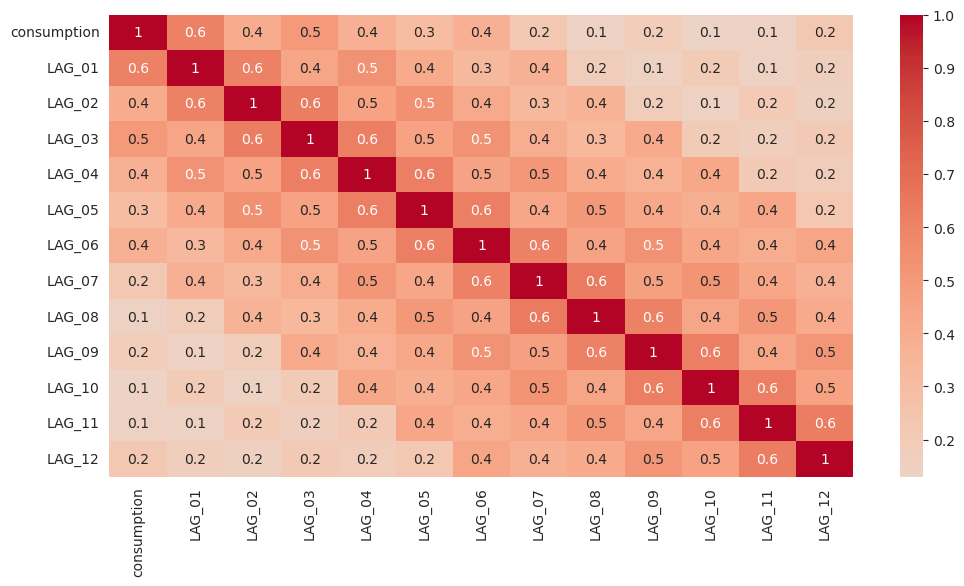

In [9]:
columns = df.to_pandas().filter(like="LAG_").columns.tolist()
columns.insert(0, "consumption")

corr_matrix = df[columns].dropna().to_pandas().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()

### Climatic and COVID Variables

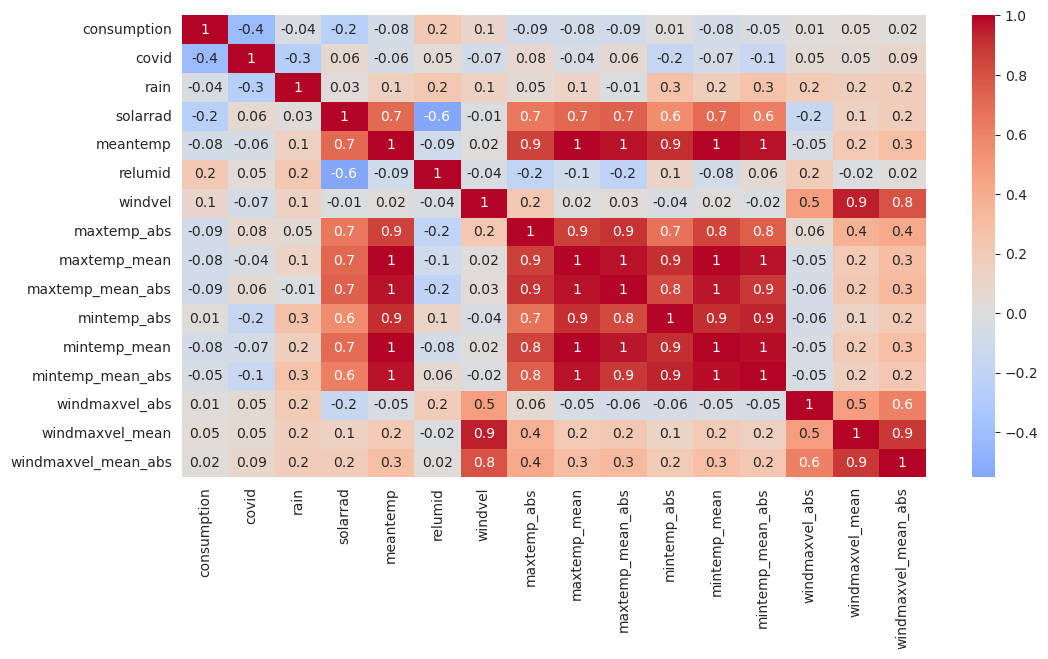

In [10]:
corr_matrix = df.drop(df.to_pandas().filter(like="LAG_").columns,
                      axis=1).drop(df.to_pandas().filter(like="month_").columns,
                                   axis=1).drop(df.to_pandas().filter(like="year_").columns,
                                                axis=1).dropna().to_pandas().corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()


# SHAP values Analysis


### Random Forest

In [11]:
df_copy = df.copy().to_pandas()

x_electricity = df_copy.drop("consumption", axis=1)
y_electricity = df_copy["consumption"]
model_rf = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=SEED)
shap.initjs()

model_rf.fit(x_electricity, y_electricity)

explainer_rf = shap.Explainer(model_rf)
shap_rf = explainer_rf(x_electricity)

importance_rf = pandas.DataFrame(list(zip(x_electricity.columns, np.abs(shap_rf.values).mean(0))),
                                 columns=["feature", "rf importance"])
importance_rf = importance_rf.sort_values(by=["rf importance"])
importance_rf

,feature,rf importance
39,year_2017,0.000000
32,month_JUN,0.796520
46,year_2024,1.477337
38,month_DEZ,1.497632
33,month_JUL,1.882618
35,month_SET,2.034362
30,month_ABR,2.047440
34,month_AGO,2.374549
43,year_2021,2.401500
37,month_NOV,2.755783


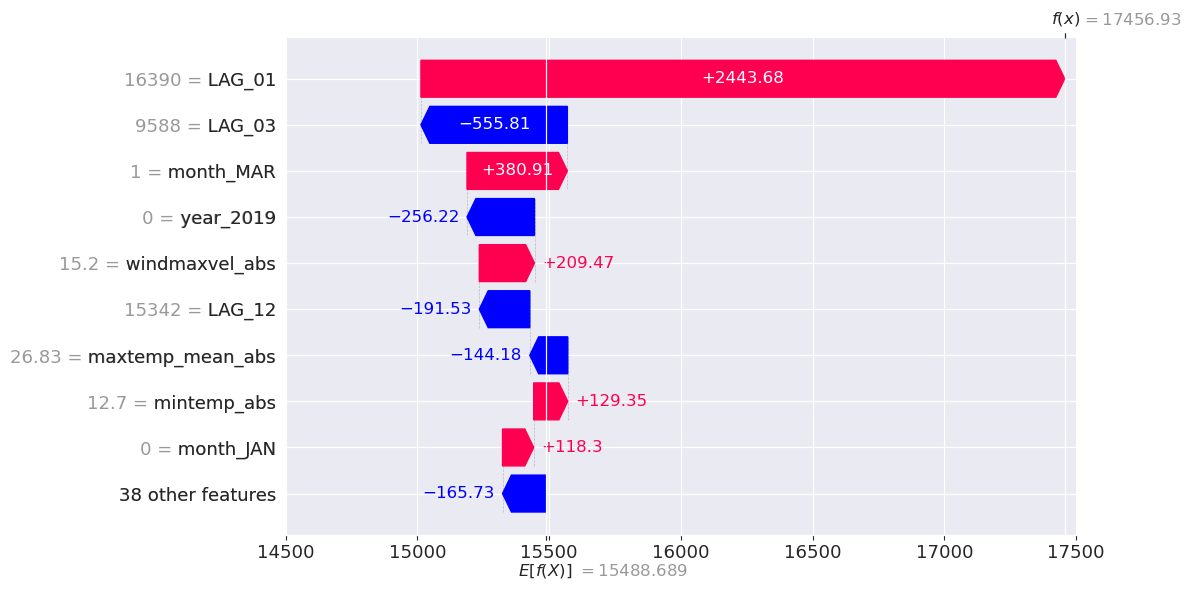

In [12]:
plt.figure(figsize=(12, 6))
colors.blue_rgb = "blue"
shap.plots.waterfall(shap_rf[-1], max_display=10, show=False)
plt.gcf().set_size_inches(12, 6)


for ax in plt.gcf().get_axes():
    ax.set_xlim(14500, 17500)
    
plt.tight_layout()
plt.savefig("results - Palmas 12m/Feature Select - SHAP WATERFALL RF.png", bbox_inches='tight')
plt.show()

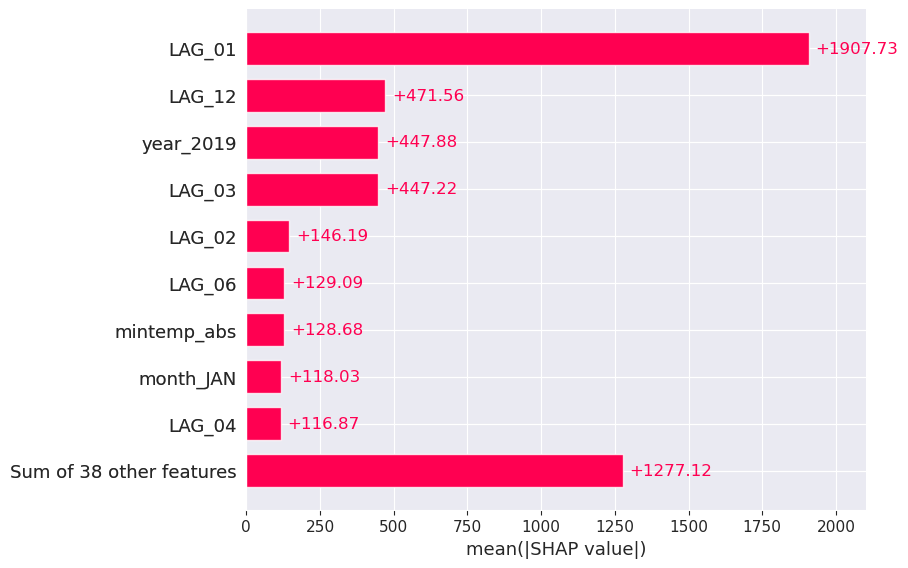

In [13]:
shap.plots.bar(shap_rf)


### XGBoost

In [14]:
df_copy = df.copy().to_pandas()

x_electricity = df_copy.drop("consumption", axis=1)
y_electricity = df_copy["consumption"]

model_xgb = XGBRegressor(booster="gbtree", objective='reg:squarederror', random_state=SEED)
shap.initjs()

model_xgb.fit(x_electricity, y_electricity)

explainer_xgb = shap.Explainer(model_xgb)
shap_xgb = explainer_xgb(x_electricity)

importance_xgb = pandas.DataFrame(list(zip(x_electricity.columns, np.abs(shap_xgb.values).mean(0))),
                                  columns=["feature", "xgb importance"])
importance_xgb = importance_xgb.sort_values(by=["xgb importance"])
importance_xgb

,feature,xgb importance
34,month_AGO,0.000000
45,year_2023,0.000000
43,year_2021,0.000000
40,year_2018,0.000000
39,year_2017,0.000000
38,month_DEZ,0.000000
28,month_FEV,0.000000
35,month_SET,0.000000
22,mintemp_mean,0.000000
30,month_ABR,0.000000


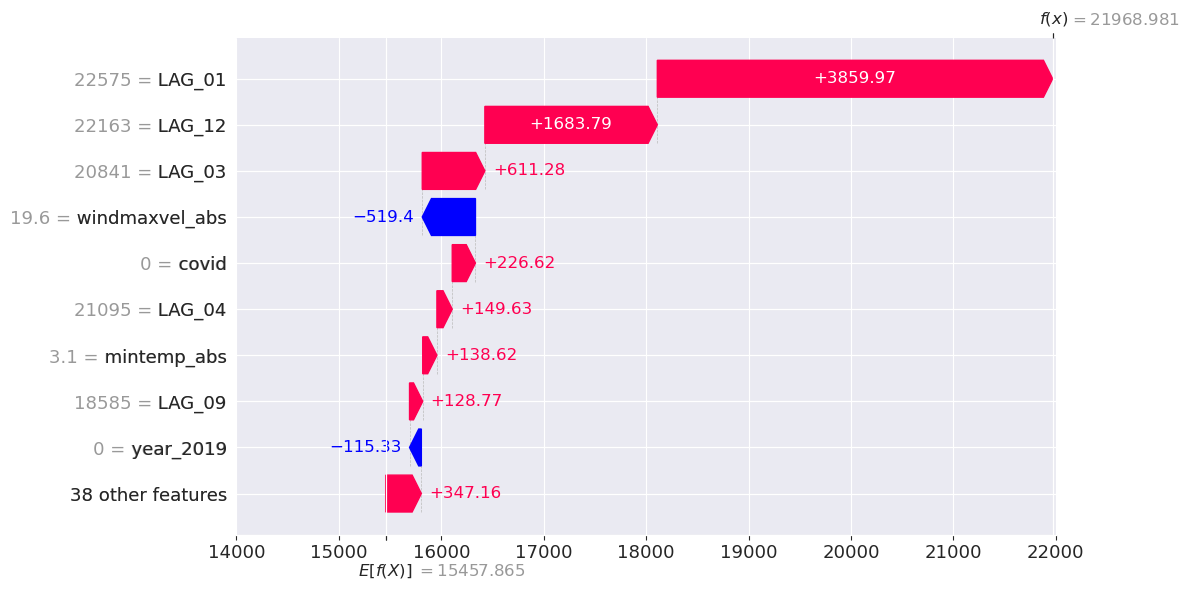

In [15]:
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap_xgb[0], max_display=10, show=False)
plt.gcf().set_size_inches(12, 6)

for ax in plt.gcf().get_axes():
    ax.set_xlim(14000, 22000)

plt.tight_layout()
plt.savefig("results - Palmas 12m/Feature Select - SHAP WATERFALL XGB.png", bbox_inches='tight')
plt.show()


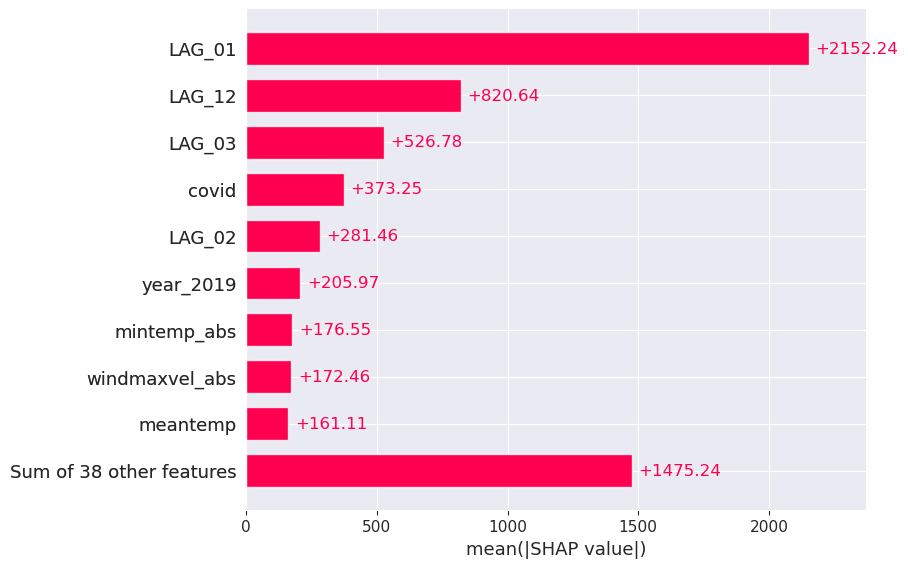

In [16]:
shap.plots.bar(shap_xgb)


### Average - RF and XGB

In [17]:
importance = pandas.DataFrame(list(zip(x_electricity.columns, (
        np.abs(shap_rf.values).mean(0) + np.abs(shap_xgb.values).mean(0)) / 2)),
                              columns=["feature", "Mean RF/XGB importance"])

importance = importance.sort_values(by=["Mean RF/XGB importance"])
importance


,feature,Mean RF/XGB importance
39,year_2017,0.000000
32,month_JUN,0.398260
46,year_2024,0.738752
38,month_DEZ,0.748816
33,month_JUL,0.957908
35,month_SET,1.017181
30,month_ABR,1.023720
34,month_AGO,1.187275
43,year_2021,1.200750
45,year_2023,2.164791


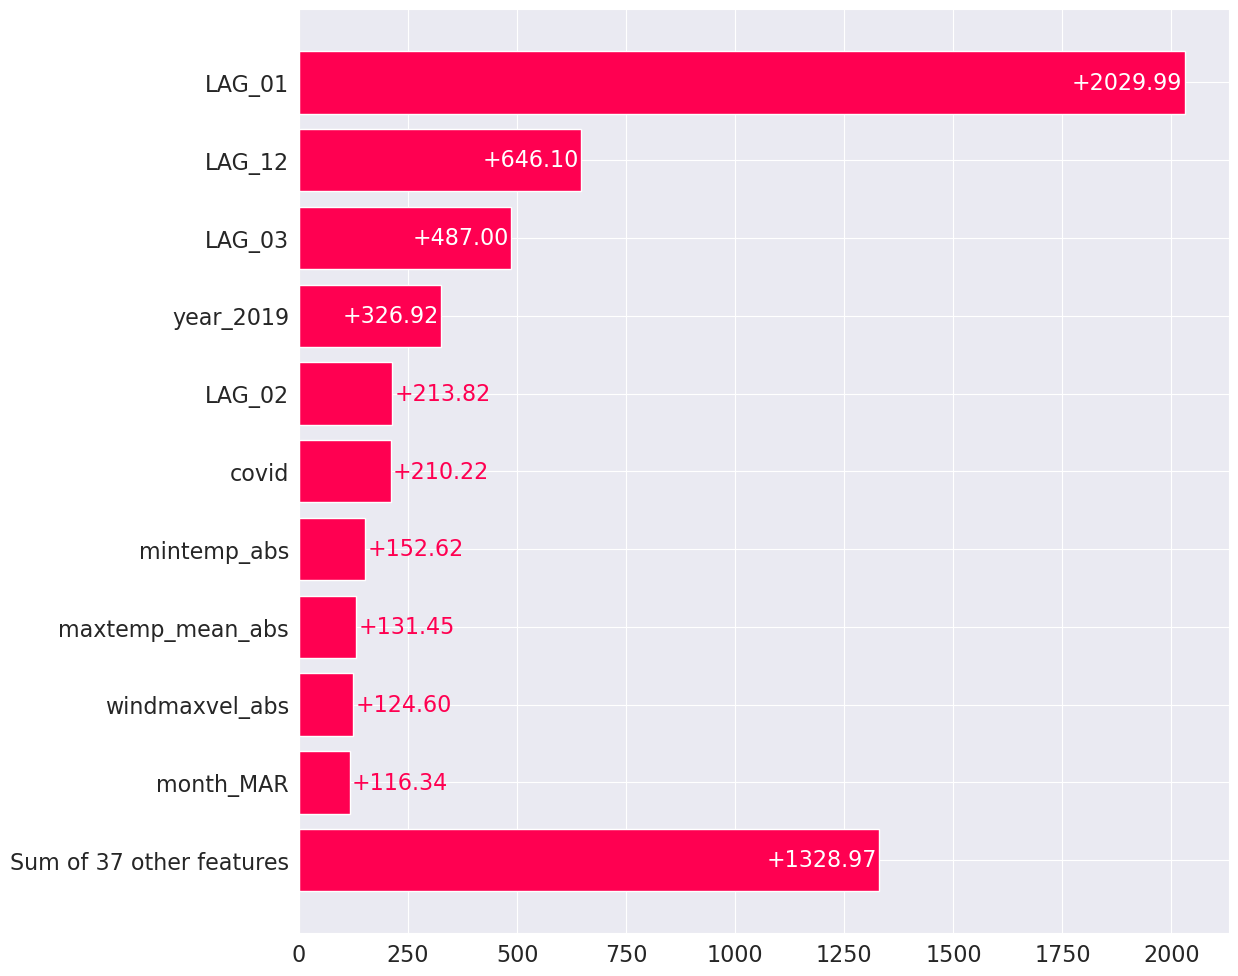

In [20]:
importance = importance.sort_values(by=["Mean RF/XGB importance"], ascending=False)

bar_features = list(importance[0:10]["feature"])
bar_features.append(f"Sum of {len(importance[10:])} other features")
bar_importances_electr = list(importance[0:10]["Mean RF/XGB importance"])
bar_importances_electr.append(importance[10:]["Mean RF/XGB importance"].sum())

bar_features = bar_features[::-1]
bar_importances_electr = bar_importances_electr[::-1]

plt.figure(figsize=(12, 12))
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams.update({'font.size': 16})

bars = plt.barh(bar_features, bar_importances_electr, color=colors.red_rgb)

for bar, val in zip(bars, bar_importances_electr):
    plt.text(bar.get_width() + 5 if val < 300 else bar.get_width() -5, bar.get_y() + bar.get_height() / 2, f'+{val:.2f}',
             va='center', ha='left' if val < 300 else 'right', color=colors.red_rgb if val < 300 else "white")

plt.savefig("results - Palmas 12m/Importance RF XGB.png", bbox_inches='tight')
plt.show()

# Features Selection


In [ ]:
importance = importance.sort_values(by=["Mean RF/XGB importance"])


def ft_removal_rf(n_ft_removed, dataset):
    df_selected = dataset[n_ft_removed:]["feature"]
    x = df[df_selected]
    y = df["consumption"]

    rf = CudaRandomForest(n_bins=x.shape[0], random_state=SEED)

    cvs_rf = []
    for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
        x_train, x_test = x.iloc[i_train].to_cupy(), x.iloc[i_test].to_cupy()
        y_train, y_test = y.iloc[i_train].to_cupy(), y.iloc[i_test].to_cupy()

        rf.fit(x_train, y_train)
        cvs_rf.append(int(mean_absolute_error(y_test, rf.predict(x_test))))
    return int(np.array(cvs_rf).mean())


def ft_removal_xgb(n_ft_removed, dataset):
    df_selected = dataset[n_ft_removed:]["feature"]

    x = df[df_selected]
    y = df["consumption"]

    xgb = XGBRegressor(device="cuda", random_state=SEED)

    cvs_xgb = []
    for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
        x_train, x_test = x.iloc[i_train].to_cupy(), x.iloc[i_test].to_cupy()
        y_train, y_test = y.iloc[i_train].to_cupy(), y.iloc[i_test].to_cupy()

        xgb.fit(x_train, y_train)
        cvs_xgb.append(int(mean_absolute_error(y_test, xgb.predict(x_test))))

    return int(np.array(cvs_xgb).mean())


importance = importance.sort_values(by=["Mean RF/XGB importance"])

ft_rm_rf = dask.compute(
    [dask.delayed(ft_removal_rf)(i, importance) for i in range(importance["feature"].shape[0])])[0]
ft_rm_xgb = dask.compute(
    [dask.delayed(ft_removal_xgb)(i, importance) for i in range(importance["feature"].shape[0])])[0]


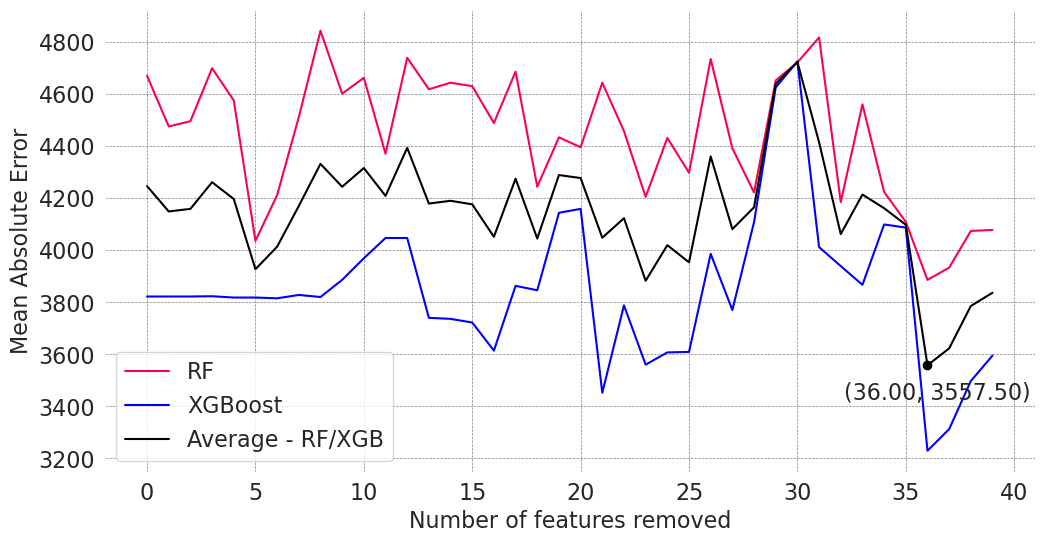

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_06,LAG_12,maxtemp_mean_abs,mintemp_abs,windmaxvel_abs,month_MAR,year_2019
date,,,,,,,,,,,,
2018-09-30,21969.0,0.0,22575.0,17751.0,20841.0,18671.0,22163.0,22.250000,3.100000,19.600000,0.0,0.0
2018-10-31,20174.0,0.0,21969.0,22575.0,17751.0,21052.0,19732.0,22.370001,7.500000,18.000000,0.0,0.0
2018-11-30,19998.0,0.0,20174.0,21969.0,22575.0,21095.0,20742.0,26.120001,11.200000,16.600000,0.0,0.0
2018-12-31,20426.0,0.0,19998.0,20174.0,21969.0,20841.0,18585.0,27.760000,6.900000,19.100000,0.0,0.0
2019-01-31,10732.0,0.0,20426.0,19998.0,20174.0,17751.0,10280.0,28.320000,16.200001,15.800000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,12207.0,0.0,11286.0,11897.0,21955.0,16964.0,14326.0,24.910000,4.300000,16.200001,0.0,0.0
2023-12-31,9588.0,0.0,12207.0,11286.0,11897.0,16655.0,12500.0,27.150000,11.800000,15.700000,0.0,0.0
2024-01-31,8226.0,0.0,9588.0,12207.0,11286.0,21165.0,10272.0,26.299999,10.600000,16.700001,0.0,0.0


In [29]:
ft_rm_mean = (np.array(ft_rm_rf) + np.array(ft_rm_xgb)) / 2
min_index = np.argmin(ft_rm_mean[:40])

plt.figure(figsize=(12, 6))
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams.update({'font.size': 16})
plt.plot([x for x in ft_rm_rf[:40]], label="RF", color=colors.red_rgb)
plt.plot([x for x in ft_rm_xgb[:40]], label="XGBoost", color="blue")
plt.plot([x for x in ft_rm_mean[:40]], label="Average - RF/XGB", color="black")
plt.scatter(min_index, ft_rm_mean[min_index], color='black', zorder=2)
plt.annotate(f"({min_index:.2f}, {ft_rm_mean[min_index]:.2f})", xy=(min_index, ft_rm_mean[min_index]),
             xytext=(-60, -25), textcoords='offset points', fontsize=16)

plt.xlabel('Number of features removed')
plt.ylabel('Mean Absolute Error')
ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.savefig("results - Palmas 12m/Feature Removal.png", bbox_inches='tight')
plt.show()
importance = importance.sort_values(by=["Mean RF/XGB importance"])
df_selected = df.drop(importance[:min_index]["feature"], axis=1)
df_selected.to_pandas().to_csv(f"dataset - Palmas/elect_merged_selected.csv", sep=";", decimal=",")
df_selected